# Final Capstone
## Twitter sentiment vs. stock data

For this project, we will see if overall sentiment value of a certain hashtag corresponding to a company will affect, in one way or another, the company's stock market price. 

The twitter data I will be using will be all the tweets that was recorded from 2015 to 2019 with the hashtag #AAPL. The stock data will be retrieved from yahoo finances with the same dates. For modelling, I will utilize time series forecasting using linear regression and random forest regresion.


In [420]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [421]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from textblob import TextBlob
from datetime import datetime, date
import plotly.express as px
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [422]:
data_url_apple = '/content/AAPL_df.csv'

df_apple = pd.read_csv(data_url_apple)

In [423]:
# taking a brief look at the dataframe, looking at the columns and such...

df_apple.head()

,Unnamed: 0,tweet_id,writer,body,comment_num,retweet_num,like_num,ticker_symbol,date
0,0,550441509175443456,VisualStockRSRC,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1,AAPL,2015-01-01 00:00:57
1,1,550441672312512512,KeralaGuy77,Insanity of today weirdo massive selling. $aap...,0,0,0,AAPL,2015-01-01 00:01:36
2,4,550443807834402816,i_Know_First,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,AAPL,2015-01-01 00:10:05
3,6,550443808606126081,aaplstocknews,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,AAPL,2015-01-01 00:10:05
4,8,550443809700851716,iknowfirst,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,AAPL,2015-01-01 00:10:05


In [424]:
# taking a look at how many rows we're dealing with 

df_apple.count()

Unnamed: 0       1425013
tweet_id         1425013
writer           1414802
body             1425013
comment_num      1425013
retweet_num      1425013
like_num         1425013
ticker_symbol    1425013
date             1425013
dtype: int64

## Data Preprocessing

In [425]:
# converting date column to datetime obj, and then keeping date only
# and resetting index for readability

df_apple['date'] = pd.to_datetime(df_apple['date'], utc=True)

start_date = pd.to_datetime('2017-01-01', utc=True)
end_date = pd.to_datetime('2019-01-02', utc=True)
df_apple = df_apple[(df_apple['date'] > start_date) & (df_apple['date'] < end_date)]
df_apple['date'] = pd.to_datetime(df_apple['date']).dt.date
df_apple = df_apple.reset_index()
df_apple.head()

,index,Unnamed: 0,tweet_id,writer,body,comment_num,retweet_num,like_num,ticker_symbol,date
0,765822,1786169,815346819710545920,anthonygutridge,How To Improve Your #trading Using These 3 Key...,0,1,0,AAPL,2017-01-01
1,765823,1786170,815347055753359364,PortfolioBuzz,See why these assets are trending in 1 watchli...,0,0,0,AAPL,2017-01-01
2,765824,1786171,815348032287838209,MacHashNews,Review: Bragi's Headphone offers a solid alter...,0,2,0,AAPL,2017-01-01
3,765825,1786172,815349029022367745,letsinvestnow,$SPX $SPY $COMPQ $QQQ $RUT $DJIA $DIA $VIX $US...,0,1,2,AAPL,2017-01-01
4,765826,1786173,815350096011280384,OphirGottlieb,"It feels like a secret, but there is an answer...",0,4,4,AAPL,2017-01-01


In [426]:
# function pipelines for cleaning twitter text data

def cleantext2(text):
  text = text.lower()
  replacements = [('(@[A-Za-z0-9_]+)', ''), ('http://\S+|https://\S+', ''), ('[^\w\s]', '')]
  for pat, repl in replacements:
    regex = re.compile(pat)
    text = re.sub(regex, repl, text)
  return text

In [427]:
# by default, stopwords are iterated for every single character in initial text and stopwords for every token. 
# turning them into sets resolves the painstaking waiting time of 2+ hours

stop_words = set(stopwords.words())

In [428]:
def clean_stop(text):
  text = ' '.join([word for word in word_tokenize(text) if not word in stop_words])
  return text

In [429]:
# applying our cleaning pipeline on the text data

cleaned_text_apple = df_apple['body'].apply(cleantext2)

In [430]:
cleaned_text_apple_nostop = cleaned_text_apple.apply(clean_stop)
cleaned_text_apple_nostop

0         improve trading using 3 key factors aapl nflx ...
1         see assets trending 1 watchlist fintech aapl b...
2         review bragis headphone offers solid alternati...
3         spx spy compq qqq rut djia vix uso aapl study ...
4         feels like secret answerspy qqq xlf ibb aapl n...
                                ...                        
442423    video watchlist 122019 spy qqq xlk xlf aapl am...
442424    join well get stock like aapl f free make sure...
442425         traders sell shares apple aapl strength aapl
442426    aapl patent maintenance event exp patent expir...
442427                traders sell apple aapl strength aapl
Name: body, Length: 442428, dtype: object

In [431]:
cleaned_text_apple_nostop.count()

442428

In [432]:
df_apple['cleaned_text'] = cleaned_text_apple_nostop

In [433]:
# applying a lambda function to calculate sentiment value of each cleaned text

df_apple['sentiment_value'] = df_apple['cleaned_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

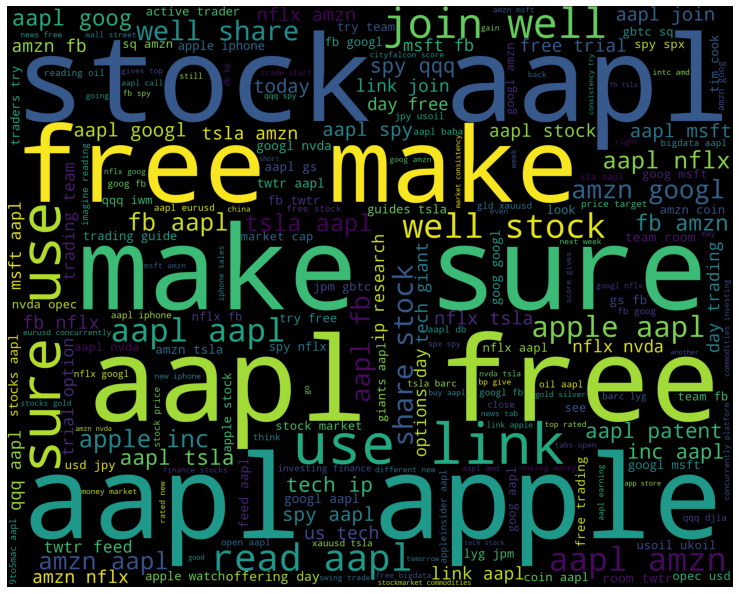

In [434]:
# creating a word cloud to visualize common words of 

twt= ' '.join(df_apple['cleaned_text'])
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', width=2500, height=2000).generate(twt)
plt.figure(figsize=(13,13))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [435]:
df_apple.drop(columns=['index', 'Unnamed: 0', 'body', 'ticker_symbol'], inplace=True)

In [436]:
df_apple.head()

,tweet_id,writer,comment_num,retweet_num,like_num,date,cleaned_text,sentiment_value
0,815346819710545920,anthonygutridge,0,1,0,2017-01-01,improve trading using 3 key factors aapl nflx ...,0.00
1,815347055753359364,PortfolioBuzz,0,0,0,2017-01-01,see assets trending 1 watchlist fintech aapl b...,0.00
2,815348032287838209,MacHashNews,0,2,0,2017-01-01,review bragis headphone offers solid alternati...,0.05
3,815349029022367745,letsinvestnow,0,1,2,2017-01-01,spx spy compq qqq rut djia vix uso aapl study ...,0.00
4,815350096011280384,OphirGottlieb,0,4,4,2017-01-01,feels like secret answerspy qqq xlf ibb aapl n...,-0.40


In [437]:
# creating a new feature with some weight to retweet and like numbers

df_apple['sentiment_feature'] = df_apple['sentiment_value'] * (1 + 0.1 * df_apple['retweet_num'] + 0.1* df_apple['like_num'])
df_apple.head()

df_apple.describe()

,tweet_id,comment_num,retweet_num,like_num,sentiment_value,sentiment_feature
count,4.424280e+05,442428.000000,442428.000000,442428.000000,442428.000000,442428.000000
mean,9.465182e+17,0.183368,0.615565,1.289568,0.111268,0.129625
std,7.947770e+16,1.353865,7.985189,8.477751,0.240923,0.424218
min,8.153468e+17,0.000000,0.000000,0.000000,-1.000000,-57.800000
25%,8.773216e+17,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.490123e+17,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.017860e+18,0.000000,0.000000,1.000000,0.250000,0.260000
max,1.080252e+18,348.000000,967.000000,865.000000,1.000000,52.450000


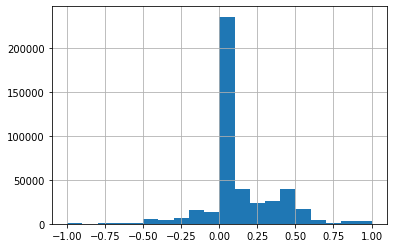

In [438]:
df_apple['sentiment_value'].hist(bins=20)

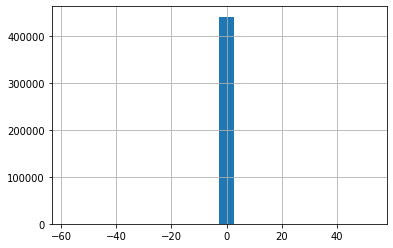

In [439]:
df_apple['sentiment_feature'].hist(bins=20)

In [440]:
# creating a new dataframe in preparation for incorporating stock data

df_aapl = pd.DataFrame(columns=['date', 'sentiment_feature', 'likes', 'retweets', 'comments'])
df_aapl['date'] = df_apple['date']
df_aapl['sentiment_feature'] = df_apple['sentiment_feature']
df_aapl['likes'] = df_apple['like_num']
df_aapl['retweets'] = df_apple['retweet_num']
df_aapl['comments'] = df_apple['comment_num']

In [441]:
# aggregating based on day, and taking the median of sentiment value



df_agg = df_aapl.groupby(df_aapl['date'])[['sentiment_feature']].mean().reset_index()
df_agg['count'] = df_agg['date'].map(df_aapl['date'].value_counts())

df_agg.head()

,date,sentiment_feature,count
0,2017-01-01,0.089885,312
1,2017-01-02,0.090774,483
2,2017-01-03,0.080825,759
3,2017-01-04,0.084392,871
4,2017-01-05,0.076184,1119


In [442]:
# getting sum of likes, retweets and comments with the aggregation into dates

df_agg2 = df_aapl.groupby(df_aapl['date'])[['likes']].sum().reset_index()
df_agg3 = df_aapl.groupby(df_aapl['date'])[['retweets']].sum().reset_index()
df_agg4 = df_aapl.groupby(df_aapl['date'])[['comments']].sum().reset_index()

In [443]:
df_agg['likes'] = df_agg2['likes']
df_agg['retweets'] = df_agg3['retweets']
df_agg['comments'] = df_agg4['comments']

In [444]:
df_agg.head()

,date,sentiment_feature,count,likes,retweets,comments
0,2017-01-01,0.089885,312,193,173,21
1,2017-01-02,0.090774,483,276,168,32
2,2017-01-03,0.080825,759,427,312,43
3,2017-01-04,0.084392,871,471,369,35
4,2017-01-05,0.076184,1119,450,306,54


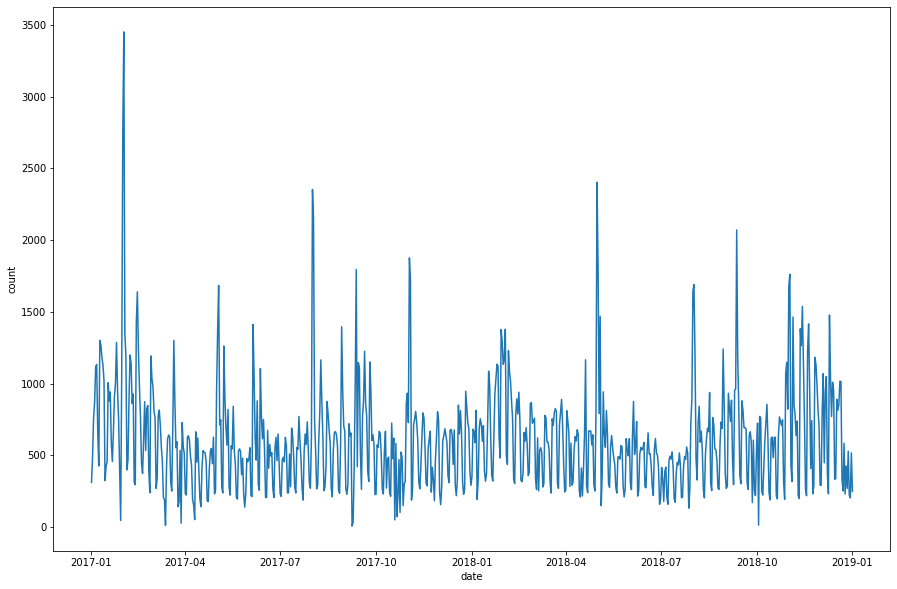

In [445]:
plt.figure(figsize=(15,10))
sns.lineplot(x='date', y='count', data=df_agg)
plt.show()

In [446]:
# importing apple stock data of relevant dates

apple_stock = pd.read_csv('/content/AAPL.csv')
apple_stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-03,28.950001,29.082500,28.690001,29.037500,27.459938,115127600
1,2017-01-04,28.962500,29.127501,28.937500,29.004999,27.429203,84472400
2,2017-01-05,28.980000,29.215000,28.952499,29.152500,27.568691,88774400
3,2017-01-06,29.195000,29.540001,29.117500,29.477501,27.876030,127007600
4,2017-01-09,29.487499,29.857500,29.485001,29.747499,28.131361,134247600


In [447]:
# Renaming the date to be in line with readability

apple_stock['date'] = apple_stock['Date']
apple_stock.drop(columns='Date', inplace=True)

In [448]:
# setting index as the dates in preparation for merging

df_agg['date'] = pd.to_datetime(df_agg['date'])
df_agg = df_agg.set_index('date')

apple_stock['date'] = pd.to_datetime(apple_stock['date'])
apple_stock = apple_stock.set_index('date')

In [449]:
# successfully merged two dataframes

merged = pd.concat([df_agg, apple_stock], axis=1)
merged.head()

,sentiment_feature,count,likes,retweets,comments,Open,High,Low,Close,Adj Close,Volume
date,,,,,,,,,,,
2017-01-01,0.089885,312,193,173,21,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,0.090774,483,276,168,32,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03,0.080825,759,427,312,43,28.950001,29.082500,28.690001,29.037500,27.459938,115127600.0
2017-01-04,0.084392,871,471,369,35,28.962500,29.127501,28.937500,29.004999,27.429203,84472400.0
2017-01-05,0.076184,1119,450,306,54,28.980000,29.215000,28.952499,29.152500,27.568691,88774400.0


In [450]:
# forwarding filling the null values because stock is in stasis during weekends

merged = merged.ffill(axis=0)

In [451]:
merged['date'] = merged.index
merged.reset_index(drop=True, inplace=True)

In [452]:
merged.drop(columns=['count', 'likes', 'retweets', 'comments', 'Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)

In [453]:
merged.describe()

,sentiment_feature,Close
count,731.000000,729.000000
mean,0.136673,42.404496
std,0.045026,6.545386
min,-0.085533,29.004999
25%,0.105370,37.755001
50%,0.136013,42.122501
75%,0.166249,46.375000
max,0.303724,58.017502


In [454]:
merged.head()

,sentiment_feature,Close,date
0,0.089885,NaN,2017-01-01
1,0.090774,NaN,2017-01-02
2,0.080825,29.037500,2017-01-03
3,0.084392,29.004999,2017-01-04
4,0.076184,29.152500,2017-01-05


In [455]:
merged_ml = merged.copy()

In [456]:
merged_ml.head()

,sentiment_feature,Close,date
0,0.089885,NaN,2017-01-01
1,0.090774,NaN,2017-01-02
2,0.080825,29.037500,2017-01-03
3,0.084392,29.004999,2017-01-04
4,0.076184,29.152500,2017-01-05


## Time Series Preprocessing

In [457]:
# function to plot time series of stock data and sentiment

def ilinechart(df, x, y, groups=None, title=""):
    fig = px.line(df, x=x, y=y, color=groups, title=title, template="none")
    
    if groups != None:
        for item in range(len(fig.data)):
            fig.data[item].update(name=fig.data[item]['name'].split('=')[1])
    fig.show()

In [458]:
# function for displaying results of model

def results(y_train, y_test, y_train_pred, y_test_pred, title="", scores=True, scatter=True, line=False):
    if scores==True:
        print('Train')
        print(f'R-squared: {r2_score(y_train, y_train_pred):.4f}')
        print(f'MAE: {mean_absolute_error(y_train, y_train_pred):.2f}')
        print(f'RMSE: {mean_squared_error(y_train, y_train_pred, squared=False):.2f}')
        print('\nTest')
        print(f'R-squared: {r2_score(y_test, y_test_pred):.4f}')
        print(f'MAE: {mean_absolute_error(y_test, y_test_pred):.2f}')
        print(f'RMSE: {mean_squared_error(y_test, y_test_pred, squared=False):.2f}')
    train_results = pd.DataFrame({'Observed': y_train, 'Predicted': y_train_pred})
    train_results['Set'] = 'Train'
    test_results = pd.DataFrame({'Observed': y_test, 'Predicted': y_test_pred})
    test_results['Set'] = 'Test'
    results = pd.concat([train_results, test_results])
    if line==True:
        melted = results.reset_index().melt(id_vars=['date', 'Set'], value_vars=['Observed', 'Predicted'])
        melted['variable'] = melted['Set'] + ' ' + melted['variable']
        ilinechart(melted, x='date', y='value', groups='variable', title=title)

In [459]:
ilinechart(merged, x='date', y='Close')

In [460]:
ilinechart(merged, x='date', y='sentiment_feature')

## Time series random forest regression with sentiment values

In [461]:
merged_ml = merged.copy()

In [462]:
history = 3
future = 3

shifts = [x + future for x in list(range(1, history+1))]
print(shifts)

[4, 5, 6]


In [463]:
for shift in shifts:
  merged_ml['sentiment_t-' + str(shift)] = merged_ml['sentiment_feature'].shift(shift)

merged_ml.head()

,sentiment_feature,Close,date,sentiment_t-4,sentiment_t-5,sentiment_t-6
0,0.089885,NaN,2017-01-01,NaN,NaN,NaN
1,0.090774,NaN,2017-01-02,NaN,NaN,NaN
2,0.080825,29.037500,2017-01-03,NaN,NaN,NaN
3,0.084392,29.004999,2017-01-04,NaN,NaN,NaN
4,0.076184,29.152500,2017-01-05,0.089885,NaN,NaN


In [464]:
merged_ml.dropna(inplace=True)
merged_ml = merged_ml.set_index('date')
merged_ml.head()

,sentiment_feature,Close,sentiment_t-4,sentiment_t-5,sentiment_t-6
date,,,,,
2017-01-07,0.078957,29.477501,0.080825,0.090774,0.089885
2017-01-08,0.090526,29.477501,0.084392,0.080825,0.090774
2017-01-09,0.140940,29.747499,0.076184,0.084392,0.080825
2017-01-10,0.079975,29.777500,0.084482,0.076184,0.084392
2017-01-11,0.064332,29.937500,0.078957,0.084482,0.076184


In [465]:
X = merged_ml.drop(columns=['Close'])
y = merged_ml['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [466]:
forest_model = RandomForestRegressor(max_depth=5)
forest_model.fit(X_train, y_train)
y_train_pred = forest_model.predict(X_train)
y_test_pred = forest_model.predict(X_test)

In [467]:
results(y_train, y_test, y_train_pred, y_test_pred, title='Random Forest Regression', line=True)

Train
R-squared: 0.7011
MAE: 2.02
RMSE: 2.64

Test
R-squared: -1.8057
MAE: 9.53
RMSE: 10.33


# Time series linear regression from sentiment value

In [468]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

In [469]:
results(y_train, y_test, y_train_pred, y_test_pred, title='Linear Regression', line=True)

Train
R-squared: 0.4559
MAE: 2.75
RMSE: 3.56

Test
R-squared: -2.0403
MAE: 9.84
RMSE: 10.76


# Time series random forest regression with t history values

In [470]:
merged_ml = merged.copy()

In [471]:
merged_ml.head()

,sentiment_feature,Close,date
0,0.089885,NaN,2017-01-01
1,0.090774,NaN,2017-01-02
2,0.080825,29.037500,2017-01-03
3,0.084392,29.004999,2017-01-04
4,0.076184,29.152500,2017-01-05


In [472]:
for shift in shifts:
  merged_ml['t-' + str(shift)] = merged_ml['Close'].shift(shift)

In [473]:
merged_ml.dropna(inplace=True)
merged_ml = merged_ml.set_index('date')
merged_ml.head()

,sentiment_feature,Close,t-4,t-5,t-6
date,,,,,
2017-01-09,0.140940,29.747499,29.152500,29.004999,29.037500
2017-01-10,0.079975,29.777500,29.477501,29.152500,29.004999
2017-01-11,0.064332,29.937500,29.477501,29.477501,29.152500
2017-01-12,0.105922,29.812500,29.477501,29.477501,29.477501
2017-01-13,0.083705,29.760000,29.747499,29.477501,29.477501


In [474]:
X = merged_ml.drop(columns=['Close', 'sentiment_feature'])
y = merged_ml['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [475]:
forest_model = RandomForestRegressor(max_depth=5)
forest_model.fit(X_train, y_train)
y_train_pred = forest_model.predict(X_train)
y_test_pred = forest_model.predict(X_test)

In [476]:
results(y_train, y_test, y_train_pred, y_test_pred, title='Random Forest Regression', line=True)

Train
R-squared: 0.9797
MAE: 0.49
RMSE: 0.68

Test
R-squared: 0.7908
MAE: 2.40
RMSE: 2.82


# Time series linear regression with t values

In [477]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

In [478]:
results(y_train, y_test, y_train_pred, y_test_pred, title='Linear Regression', line=True)

Train
R-squared: 0.9630
MAE: 0.64
RMSE: 0.92

Test
R-squared: 0.9285
MAE: 1.29
RMSE: 1.65


# Time series random forest with both sentiment and t-closing values

In [479]:
merged_ml = merged.copy()

In [480]:
history = 3
future = 3

shifts = [x + future for x in list(range(1, history+1))]
print(shifts)

[4, 5, 6]


In [481]:
for shift in shifts:
  merged_ml['t-' + str(shift)] = merged_ml['Close'].shift(shift)
  merged_ml['sentiment t-' + str(shift)] = merged_ml['sentiment_feature'].shift(shift)

In [482]:
merged_ml.dropna(inplace=True)
merged_ml = merged_ml.set_index('date')
merged_ml.head()

,sentiment_feature,Close,t-4,sentiment t-4,t-5,sentiment t-5,t-6,sentiment t-6
date,,,,,,,,
2017-01-09,0.140940,29.747499,29.152500,0.076184,29.004999,0.084392,29.037500,0.080825
2017-01-10,0.079975,29.777500,29.477501,0.084482,29.152500,0.076184,29.004999,0.084392
2017-01-11,0.064332,29.937500,29.477501,0.078957,29.477501,0.084482,29.152500,0.076184
2017-01-12,0.105922,29.812500,29.477501,0.090526,29.477501,0.078957,29.477501,0.084482
2017-01-13,0.083705,29.760000,29.747499,0.140940,29.477501,0.090526,29.477501,0.078957


In [483]:
X = merged_ml.drop(columns=['Close'])
y = merged_ml['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [484]:
forest_model = RandomForestRegressor(max_depth=5)
forest_model.fit(X_train, y_train)
y_train_pred = forest_model.predict(X_train)
y_test_pred = forest_model.predict(X_test)

In [485]:
results(y_train, y_test, y_train_pred, y_test_pred, title='Random Forest Regression', line=True)

Train
R-squared: 0.9818
MAE: 0.47
RMSE: 0.65

Test
R-squared: 0.7467
MAE: 2.66
RMSE: 3.11


# Time series linear regression with both sentiment and T-values

In [486]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

In [487]:
results(y_train, y_test, y_train_pred, y_test_pred, title='Linear Regression', line=True)

Train
R-squared: 0.9637
MAE: 0.63
RMSE: 0.91

Test
R-squared: 0.9313
MAE: 1.26
RMSE: 1.62


# Conclusion/Discussion

The dataset that was primarily used was a collection of tweets that was scraped from twitter with the hashtag "#AAPL", which is title for Apple's stock in the stock market. After doing some cleaning, the sentiment value was calculated using TextBlob's sentiment polarity. The data was then aggregated based on date, and the sentiment values were averaged based on the day. Apple stock data was then retrieved to the corresponding date of the text data. Several machine learning methods was applied for forecasting: random forest regression and linear regression using sentiment data only, closing prices only and then both.

Based on the results of the models, using sentiment alone to predict stock prices was the worst of the bunch. The r squared value was very negative, and from the visual line plot, it's safe to assume that there is very little to no correlation of overall sentiment value to closing price of stock. However, with both the sentiment value and historical stock price into consideration, the r squared value ended up being 0.3 higher than just the usual historical stock price. From that alone, we could presume that sentiment value does have some factor in determining stock price, albeit very little.

There were some things that brought up some concern. In the brief analysis of the tweet data, there were some tweets that looked like it was from a bot account, that included links to a probably spam website. For future endeavors, when analyzing text, I think incorporating additional filters in removing said bot tweets could give better and more accurate sentiment values. Another concern was that the stock market remains in stasis on the weekend and holiday. Values show up as nulls on the weekend, so they were interpolated via forward filling. Though this is the easiest way without compromising amount of data. However, for future endeavors, we could try taking the mean sentiment values on the weekend and the following Monday and replace that Monday with that value.